In [1]:
import os
from tqdm import tnrange, tqdm_notebook, tqdm
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [2]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)

%matplotlib inline

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
device_ids = [0, 1]

In [6]:
batch_size = 128
num_epochs = 100

z_dimension = 100
num_feature = 56 * 56

In [7]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

dataset = datasets.MNIST('./datas/mnist', transform=img_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [8]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.LeakyReLU(.2, True),
            nn.AvgPool2d(2, 2), 
        ) # b 32 14 14
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.LeakyReLU(.2, True),
            nn.AvgPool2d(2, 2),
        ) # b 64 7 7
        
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 1024),
            nn.LeakyReLU(.2, True),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        ) # b 1
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            
    def forward(self, x): # b 1 28 28
        out = self.conv1(x)
        out = self.conv2(out)
        
        out = out.view(x.size(0), -1)
        return self.fc(out)

In [10]:
class Generator(nn.Module):
    def __init__(self, inp_dim, num_feature):
        super(Generator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(inp_dim, num_feature),
            nn.Sigmoid(),
        ) # b h*w
        self.br = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.LeakyReLU(.2, True),
        ) # b 1 56 56
        
        self.downsample1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(.2, True),
        ) # b 64 56 56
        
        self.downsample2 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(.2, True),
        ) # b 32 56 56
        
        self.downsample3 = nn.Sequential(
            nn.Conv2d(32, 1, 3, padding=1, stride=2),
            nn.Tanh(),
        ) # b 1 28 28
        
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            
    def forward(self, x):
        out = self.fc(x)
        
        out = out.view(x.size(0), 1, 56, 56)
        out = self.br(out)
        out = self.downsample1(out)
        out = self.downsample2(out)
        out = self.downsample3(out)
        return out

In [11]:
d = Discriminator().to(device)
g = Generator(z_dimension, num_feature).to(device)

d.weight_init(.0, 0.02)
g.weight_init(.0, 0.02)

d = nn.DataParallel(d, device_ids=device_ids).to(device)
g = nn.DataParallel(g, device_ids=device_ids).to(device)

criterion = nn.BCELoss()

d_optimezer = optim.Adam(d.parameters(), lr=2e-4)
g_optimezer = optim.Adam(g.parameters(), lr=2e-4)

/usr/local/lib/python2.7/dist-packages/torch/nn/parallel/data_parallel.py:24: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [12]:
writer = SummaryWriter('./log/cnn_gan')

In [13]:
total_count = len(dataloader)
for epoch in tqdm_notebook(xrange(num_epochs)):
    _step = epoch * total_count
    
    d_loss_total = .0
    g_loss_total = .0
    for i, (img, _) in enumerate(dataloader):
        
        real_img = img.cuda()
        real_labels = torch.ones(img.size(0), 1).cuda()
        fake_labels = torch.zeros(img.size(0), 1).cuda()
        
        real_out = d(real_img)
        d_loss_real = criterion(real_out, real_labels)
        real_scores = real_out
        
        z = torch.randn(img.size(0), z_dimension).cuda()
        fake_img = g(z)
        fake_out = d(fake_img)
        d_loss_fake = criterion(fake_out, fake_labels)
        fake_scores = fake_out
        
        d_loss = d_loss_real + d_loss_fake
        d_optimezer.zero_grad()
        d_loss.backward()
        d_optimezer.step()
        
        z = torch.randn(img.size(0), z_dimension).cuda()
        fake_img = g(z)
        fake_out = d(fake_img)
        g_loss = criterion(fake_out, real_labels)
        
        g_optimezer.zero_grad()
        g_loss.backward()
        g_optimezer.step()
        
        d_loss_total += d_loss.item() * img.size(0)
        g_loss_total += g_loss.item() * img.size(0)
        
        step = _step + i + 1
        
        if (i + 1) % 100 == 0:
            writer.add_scalar('Discriminator Real Loss', d_loss_real.item(), step)
            writer.add_scalar('Discriminator Fake Loss', d_loss_fake.item(), step)
            writer.add_scalar('Discriminator Loss', d_loss.item(), step)
            writer.add_scalar('Generator Loss', g_loss.item(), step)
        
        
        if (i + 1) % 300 == 0:
            tqdm.write('Epoch [{}/{}], Step: {:6d}, d_loss: {:.6f}, g_loss: {:.6f}, real_scores: {:.6f}' \
', fake_scores: {:.6f}'.format(epoch+1, num_epochs, (i+1) * batch_size, d_loss, g_loss, real_scores.mean(), fake_scores.mean()))
    
    
    setp = (epoch + 1) * total_count
    _d_loss_total = d_loss_total / (total_count * (epoch + 1))
    _g_loss_total = g_loss_total / (total_count * (epoch + 1))
    
    writer.add_scalar('Discriminator Total Loss', _d_loss_total, step)
    writer.add_scalar('Generator Total Loss', _g_loss_total, step)
    
    tqdm.write("Finish Epoch [{}/{}], D Loss: {:.6f}, G Loss: {:.6f}".format(epoch+1, 
                                                                             num_epochs, 
                                                                             _d_loss_total,
                                                                             _g_loss_total, ))
    
    writer.add_image('Generator Image', make_grid(fake_img.view(-1, 1, 28, 28).cpu().data, normalize=True, scale_each=True), step)
    
    if epoch == 0:
        real_images = real_img.view(-1, 1, 28, 28).cpu().data
        save_image(real_images, './cnn_gan_img/real_images.png')
    
    
    
    fake_images = fake_img.view(-1, 1, 28, 28).cpu().data
    save_image(fake_images, './cnn_gan_img/fake_images-{}.png'.format(epoch+1))

HBox(children=(IntProgress(value=0), HTML(value=u'')))

Epoch [1/100], Step:  38400, d_loss: 0.937766, g_loss: 1.749669, real_scores: 0.878058, fake_scores: 0.457458
Finish Epoch [1/100], D Loss: 60.760090, G Loss: 450.252879
Epoch [2/100], Step:  38400, d_loss: 0.654950, g_loss: 2.124682, real_scores: 0.680493, fake_scores: 0.126063
Finish Epoch [2/100], D Loss: 39.572537, G Loss: 123.840065
Epoch [3/100], Step:  38400, d_loss: 0.516862, g_loss: 2.454146, real_scores: 0.923992, fake_scores: 0.292242
Finish Epoch [3/100], D Loss: 19.627490, G Loss: 103.323877
Epoch [4/100], Step:  38400, d_loss: 0.444043, g_loss: 1.562260, real_scores: 0.854906, fake_scores: 0.178196
Finish Epoch [4/100], D Loss: 14.900813, G Loss: 80.510159
Epoch [5/100], Step:  38400, d_loss: 0.493465, g_loss: 2.265056, real_scores: 0.842507, fake_scores: 0.206431
Finish Epoch [5/100], D Loss: 13.175548, G Loss: 61.097728
Epoch [6/100], Step:  38400, d_loss: 0.614002, g_loss: 1.776424, real_scores: 0.841668, fake_scores: 0.223994
Finish Epoch [6/100], D Loss: 11.733626, G

Finish Epoch [49/100], D Loss: 1.391829, G Loss: 6.406394
Epoch [50/100], Step:  38400, d_loss: 0.447054, g_loss: 2.630246, real_scores: 0.872728, fake_scores: 0.174988
Finish Epoch [50/100], D Loss: 1.331816, G Loss: 6.197160
Epoch [51/100], Step:  38400, d_loss: 0.435306, g_loss: 1.666748, real_scores: 0.866076, fake_scores: 0.143217
Finish Epoch [51/100], D Loss: 1.341124, G Loss: 6.186675
Epoch [52/100], Step:  38400, d_loss: 0.435988, g_loss: 2.178784, real_scores: 0.886872, fake_scores: 0.200372
Finish Epoch [52/100], D Loss: 1.278023, G Loss: 5.969794
Epoch [53/100], Step:  38400, d_loss: 0.510413, g_loss: 2.027502, real_scores: 0.814997, fake_scores: 0.156235
Finish Epoch [53/100], D Loss: 1.279438, G Loss: 5.927099
Epoch [54/100], Step:  38400, d_loss: 0.478498, g_loss: 2.801358, real_scores: 0.833819, fake_scores: 0.163186
Finish Epoch [54/100], D Loss: 1.230781, G Loss: 5.791406
Epoch [55/100], Step:  38400, d_loss: 0.437254, g_loss: 2.746707, real_scores: 0.853616, fake_sco

Finish Epoch [98/100], D Loss: 0.604336, G Loss: 3.399274
Epoch [99/100], Step:  38400, d_loss: 0.378952, g_loss: 2.404691, real_scores: 0.876978, fake_scores: 0.142758
Finish Epoch [99/100], D Loss: 0.594537, G Loss: 3.357696
Epoch [100/100], Step:  38400, d_loss: 0.472929, g_loss: 2.992820, real_scores: 0.879532, fake_scores: 0.190114
Finish Epoch [100/100], D Loss: 0.582962, G Loss: 3.293169



In [14]:
writer.close()

In [15]:
torch.save(d.state_dict(), './ser/discriminator.pkl')
torch.save(g.state_dict(), './ser/generator.pkl')

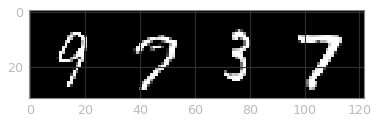

In [16]:
z = torch.randn(4, z_dimension).to(device)
images = g(z)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()